# Data Analysis

__This notebook contains the code that performs the analysis for the forecast results of the different models__

The notebook is structured as follows:
1. __Loading Datasets, Preprocessing Data__
   - Loading both CDS-dataset and Model forecasting datasets
   - Preprocessing model datasets into different dictionaries
2. __Root Mean Squared Error (RMSE) & Prediction Interval Sharpness (PIS) analysis__
   - Calculate Root Mean Squared Error and Prediction Interval Sharpness for every model (for every company)
   - Bootstrap the mean distribution for every model for both of these metrics
   - Mann Whitney U tests, to look at difference in these mean distributions
3. __Diebold-Mariano Analysis__
   - Perform Diebold-Mariano analysis on model predictions, both pairwise tests and test with all models included
4. __Plot for CDS-rates of McDonald's__
   - A simple plot that is used in the presentation, for explaining significance of comparing forecasting models in the undpredictable Covid-19 times
5. __Conclusion__
   - Reflecting on hypotheses
    


## Imports/Global settings

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

from scipy import stats
from scipy.stats import entropy, anderson, norm

import seaborn as sns

from itertools import permutations, combinations

In [2]:
#Setting our prefered font for plots globally.
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['font.family'] ='Times New Roman'

#Setting random but consistent seed
np.random.seed(seed=20)

## 1. Loading Datasets, Preprocessing data

#### (a) Loading CDS-data
- Loading in CDS-data and preprocessing as is also done before forecasting using the different models

In [3]:
#Tickers that have less than 1747 (most frequent) observations and/or have less than 1000 different valued observations are removed
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
ticks_DF_dict = {}
for tick in cds_DF.groupby('Ticker').size()[cds_DF.groupby('Ticker').size() >= 1747].index:
    if len(cds_DF[cds_DF['Ticker'] == tick]['PX1'].unique()) > 1000:
        ticks_DF_dict[tick] = cds_DF[cds_DF['Ticker'] == tick].set_index("Date")

#### (b) Loading forecasting data
- Loading in Forecasting-data and creating dictionaries for every different model. These dictionaries consist of ticker:forecasts pairs, where a ticker is a unique identifier for the specific company, and forecasts is a DataFrame which contains the 1-Day forecasts for 2020

In [4]:
ARIMA_forecast = pd.read_csv('datasets/ARIMA/ARIMA_forecast.csv', index_col=0, parse_dates=['date'])
AR_forecast = pd.read_csv('datasets/AR/AR_forecast.csv', index_col=0, parse_dates=['date'])
ARCH_forecast = pd.read_csv('datasets/ARCH/ARCH_forecast.csv', index_col=0, parse_dates=['date'])
GARCH_forecast = pd.read_csv('datasets/GARCH/GARCH_forecast.csv', index_col=0, parse_dates=['date'])
GJR_GARCH_forecast = pd.read_csv('datasets/GJR_GARCH/GJR_GARCH_forecast.csv', index_col=0, parse_dates=['date'])

In [5]:
def panelDFtoDict(panelDF):
    all_ticks = panelDF['tick'].unique()
    tDFdict = dict()
    for tick in all_ticks:
        tDF = panelDF[panelDF['tick'] == tick]
        tDFdict[tick] = tDF.set_index('date')
    return tDFdict

ARIMA_tDF = panelDFtoDict(ARIMA_forecast)
AR_tDF = panelDFtoDict(AR_forecast)
ARCH_tDF = panelDFtoDict(ARCH_forecast)
GARCH_tDF = panelDFtoDict(GARCH_forecast)
GJR_GARCH_tDF = panelDFtoDict(GJR_GARCH_forecast)

## 2. Root Mean Squared Error (RMSE) & Prediction Interval Sharpness (PIS) analysis

#### (a) Defining functions for some metrics and showing average of these metrics for all models
- We continued with the analysis for only the metrics RMSE and PIS, because we found it to be a good mix between comparing the predicted value of the forecast (RMSE) and comparing the 95%-CI intervals for the forecasts (PIS).

In [6]:
def RMSE(yhat, y):
    """Calculates the Root Mean Squared Error """
    return  np.sqrt(np.sum((y - yhat) ** 2)/len(yhat))
def MAE(yhat, y, percentage=False):
    """Calculates the Mean Absolute Error """
    if percentage:
        return np.sum(np.abs((y - yhat)/y))/len(yhat) * 100
    return  np.sum(np.abs(y - yhat))/len(yhat)
def MPIW(upper_bounds, lower_bounds):
    """Calculates the Mean Prediction Interval Width"""
    return np.sum(upper_bounds - lower_bounds)/len(upper_bounds)
def calculate_picp(actual, lower_bounds, upper_bounds):
    """Calculates the Prediction Interval Coverage Probability"""
    within_bounds = np.logical_and(actual >= lower_bounds, actual <= upper_bounds)
    picp = np.mean(within_bounds)
    return picp
def PIS(actual, lower_bounds, upper_bounds):
    """Calculates the Prediction Interval Sharpness """
    return MPIW(upper_bounds, lower_bounds) * (1 - calculate_picp(actual, lower_bounds, upper_bounds))

In [7]:
RMSE_ARIMA = [RMSE(DF['preds'].values, DF['actual'].values) for DF in ARIMA_tDF.values()]
RMSE_AR = [RMSE(DF['preds'].values, DF['actual'].values) for DF in AR_tDF.values()]
RMSE_ARCH = [RMSE(DF['preds'].values, DF['actual'].values) for DF in ARCH_tDF.values()]
RMSE_GARCH = [RMSE(DF['preds'].values, DF['actual'].values) for DF in GARCH_tDF.values()]
RMSE_GJR_GARCH = [RMSE(DF['preds'].values, DF['actual'].values) for DF in GJR_GARCH_tDF.values()]

MAE_ARIMA = [MAE(DF['preds'].values, DF['actual'].values) for DF in ARIMA_tDF.values()]
MAE_AR = [MAE(DF['preds'].values, DF['actual'].values) for DF in AR_tDF.values()]
MAE_ARCH = [MAE(DF['preds'].values, DF['actual'].values) for DF in ARCH_tDF.values()]
MAE_GARCH = [MAE(DF['preds'].values, DF['actual'].values) for DF in GARCH_tDF.values()]
MAE_GJR_GARCH = [MAE(DF['preds'].values, DF['actual'].values) for DF in GJR_GARCH_tDF.values()]

MAPE_ARIMA = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in ARIMA_tDF.values()]
MAPE_AR = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in AR_tDF.values()]
MAPE_ARCH = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in ARCH_tDF.values()]
MAPE_GARCH = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in GARCH_tDF.values()]
MAPE_GJR_GARCH = [MAE(DF['preds'].values, DF['actual'].values, percentage=True) for DF in GJR_GARCH_tDF.values()]

CR_ARIMA = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARIMA_tDF.values()]
CR_AR = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in AR_tDF.values()]
CR_ARCH = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARCH_tDF.values()]
CR_GARCH = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in GARCH_tDF.values()]
CR_GJR_GARCH = [calculate_picp(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in GJR_GARCH_tDF.values()]

PIS_ARIMA = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARIMA_tDF.values()]
PIS_AR = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in AR_tDF.values()]
PIS_ARCH = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in ARCH_tDF.values()]
PIS_GARCH = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in GARCH_tDF.values()]
PIS_GJR_GARCH = [PIS(DF['actual'], DF['lower_95'], DF['upper_95']) for DF in GJR_GARCH_tDF.values()]

In [8]:
print("ARIMA Statistics:")
print(f"Average RMSE: {np.mean(RMSE_ARIMA):.5f}")
print(f"Average MAE: {np.mean(MAE_ARIMA):.5f}")
print(f"Average MAPE: {np.mean(MAPE_ARIMA):.5f}")
print(f"Average CR: {np.mean(CR_ARIMA):.5f}")
print(f"Average PIS: {np.mean(PIS_ARIMA):.5f}")

ARIMA Statistics:
Average RMSE: 5.39330
Average MAE: 2.48767
Average MAPE: 4.47558
Average CR: 0.87465
Average PIS: 0.97860


In [9]:
print("AR Statistics:")
print(f"Average RMSE: {np.mean(RMSE_AR):.5f}")
print(f"Average MAE: {np.mean(MAE_AR):.5f}")
print(f"Average MAPE: {np.mean(MAPE_AR):.5f}")
print(f"Average CR: {np.mean(CR_AR):.5f}")
print(f"Average PIS: {np.mean(PIS_AR):.5f}")

AR Statistics:
Average RMSE: 5.33009
Average MAE: 2.44041
Average MAPE: 4.40398
Average CR: 0.87747
Average PIS: 0.96082


In [10]:
print("ARCH Statistics:")
print(f"Average RMSE: {np.mean(RMSE_ARCH):.5f}")
print(f"Average MAE: {np.mean(MAE_ARCH):.5f}")
print(f"Average MAPE: {np.mean(MAPE_ARCH):.5f}")
print(f"Average CR: {np.mean(CR_ARCH):.5f}")
print(f"Average PIS: {np.mean(PIS_ARCH):.5f}")

ARCH Statistics:
Average RMSE: 5.28100
Average MAE: 2.41223
Average MAPE: 4.40457
Average CR: 0.92636
Average PIS: 0.97045


In [11]:
print("GARCH Statistics:")
print(f"Average RMSE: {np.mean(RMSE_GARCH):.5f}")
print(f"Average MAE: {np.mean(MAE_GARCH):.5f}")
print(f"Average MAPE: {np.mean(MAPE_GARCH):.5f}")
print(f"Average CR: {np.mean(CR_GARCH):.5f}")
print(f"Average PIS: {np.mean(PIS_GARCH):.5f}")

GARCH Statistics:
Average RMSE: 5.27846
Average MAE: 2.40913
Average MAPE: 4.40279
Average CR: 0.93974
Average PIS: 0.92431


In [12]:
print("GJR-GARCH Statistics:")
print(f"Average RMSE: {np.mean(RMSE_GJR_GARCH):.5f}")
print(f"Average MAE: {np.mean(MAE_GJR_GARCH):.5f}")
print(f"Average MAPE: {np.mean(MAPE_GJR_GARCH):.5f}")
print(f"Average CR: {np.mean(CR_GJR_GARCH):.5f}")
print(f"Average PIS: {np.mean(PIS_GJR_GARCH):.5f}")

GJR-GARCH Statistics:
Average RMSE: 5.27815
Average MAE: 2.40917
Average MAPE: 4.40255
Average CR: 0.93865
Average PIS: 0.93980


#### (b) Min-Maxing RMSE and PIS values for visual plot of performance
- The RMSE and PIS values will first be min-max scaled (between 0 and 1) for every company across models. Meaning that for every company the lowest scoring models' score will be set to 0, and the highest scoring model will be set to 1. Every other models' score for that company will be proportionally scaled in between these values. This makes it possible to visually compare these metrics (RMSE and PIS) for every model across companies, due to now only capturing the relative difference between the predictions.

This scaling is particularly important because the usual CDS rates vary significantly between companies. For instance, some companies have CDS rates in the 100s, while others have rates in the 10s. As a result, RMSE values for companies with higher CDS ranges are inherently larger across all models, making direct comparisons across companies possibly misleading without normalization.

In [13]:
def find_min_max(AR, ARIMA, ARCH, GARCH, GJR):
    """This function will given the metrics_lists (e.g., RMSE) for the different models return a dictionary 
    with for every company, the maximum and minimum of this metric across the different models"""
    models = {'AR': AR.copy(), 'ARIMA': ARIMA.copy(), 'ARCH': ARCH.copy(), 'GARCH': GARCH.copy(), 'GJR': GJR.copy()}
    
    # counters
    min_counts = {model: 0 for model in models.keys()}
    max_counts = {model: 0 for model in models.keys()}
    
    # per-step min/max
    min_values = []
    max_values = []
    min_models = []
    max_models = []

    for i in range(len(AR)):
        current_rmse = {model: models[model][i] for model in models.keys()}
        
        # find minimum and maximum RMSE
        min_model = min(current_rmse, key=current_rmse.get)
        max_model = max(current_rmse, key=current_rmse.get)
        
        min_value = current_rmse[min_model]
        max_value = current_rmse[max_model]

        # append vals and models
        min_values.append(min_value)
        max_values.append(max_value)
        min_models.append(min_model)
        max_models.append(max_model)

        # increment counters
        min_counts[min_model] += 1
        max_counts[max_model] += 1

    results = {
        'min_values': min_values,
        'max_values': max_values,
        'min_counts': min_counts,
        'max_counts': max_counts
    }
    return results

In [14]:
#create the maximum and minimum metric dictionaries for the RMSE and PIS values for all models
RMSE_compared = find_min_max(RMSE_AR, RMSE_ARIMA, RMSE_ARCH, RMSE_GARCH, RMSE_GJR_GARCH)
PIS_compared = find_min_max(PIS_AR, PIS_ARIMA, PIS_ARCH, PIS_GARCH, PIS_GJR_GARCH)

In [15]:
def min_max_scaler(results, AR, ARIMA, ARCH, GARCH, GJR):
    """This function will given a maximum and minimum value for each of the companies for a given metric (e.g., RMSE),
    return a dictionary with for every model the min-maxed scaled values"""
    models = {'AR': AR.copy(), 'ARIMA': ARIMA.copy(), 'ARCH': ARCH.copy(), 'GARCH': GARCH.copy(), 'GJR': GJR.copy()}
    min_values = results['min_values']
    max_values = results['max_values']

    for i in range(len(min_values)):
        for model in models.keys():
            temp_min = min_values[i]
            temp_max = max_values[i]
            models[model][i] = (models[model][i] - temp_min)/(temp_max - temp_min)

    return models

In [16]:
#create the dictionaries for RMSE and PIS, which contain the min-maxed scaled values for every company, 
#based on the performance of the models across companies.
RMSE_scaled = min_max_scaler(RMSE_compared, RMSE_AR, RMSE_ARIMA, RMSE_ARCH, RMSE_GARCH, RMSE_GJR_GARCH)
PIS_scaled = min_max_scaler(PIS_compared, PIS_AR, PIS_ARIMA, PIS_ARCH, PIS_GARCH, PIS_GJR_GARCH)

#### (c) Creating plot to show initial differences in RMSE and PIS for different models
- Two plots with min-max scaled boxplot ans violinplot for RMSE and PIS values

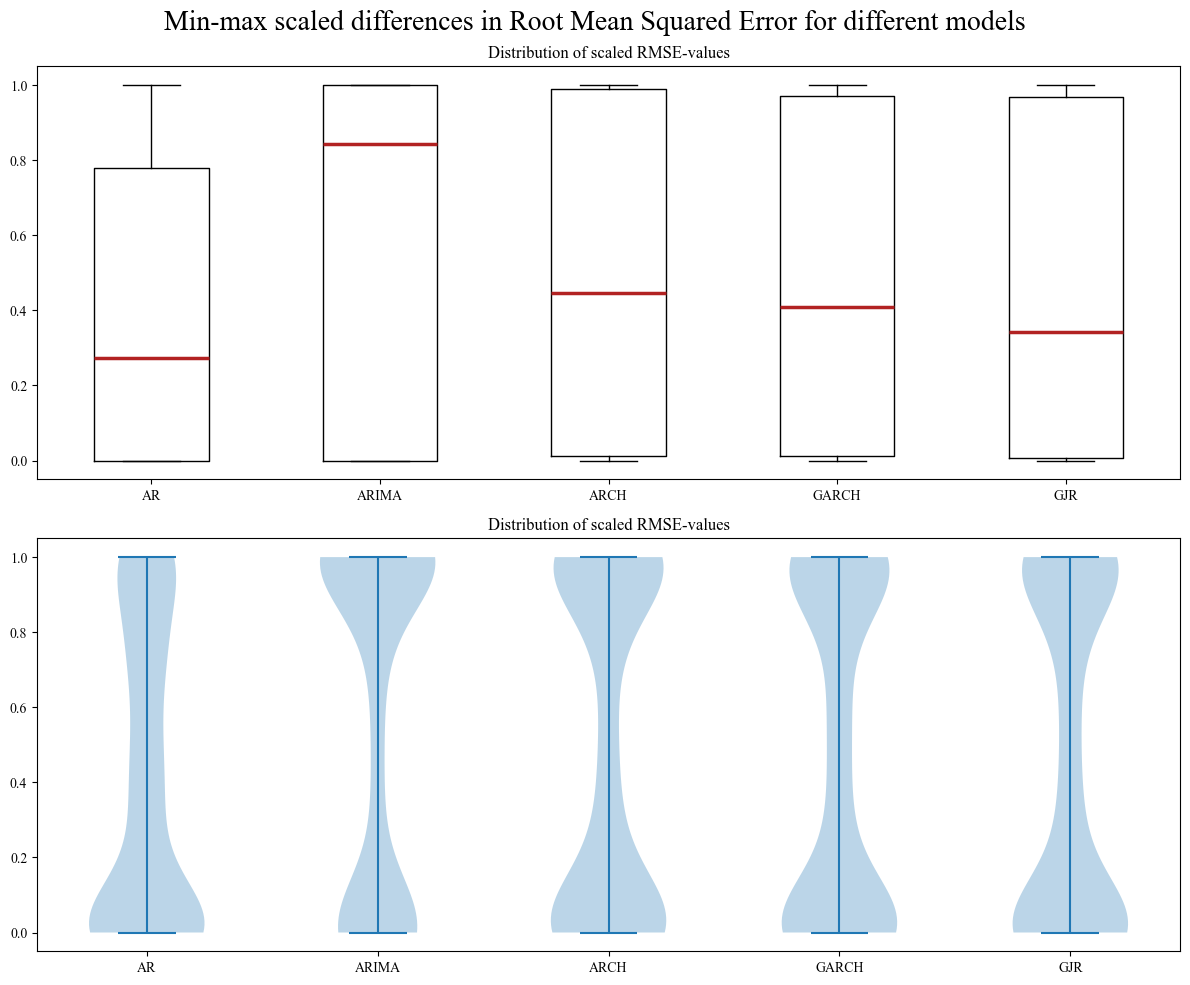

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # 2 rows, 1 column

# boxplot
axes[0].boxplot(RMSE_scaled.values(), medianprops=dict(linewidth=2.5, color='firebrick'))
axes[0].set_xticklabels(RMSE_scaled.keys())
axes[0].set_title("Distribution of scaled RMSE-values")

# violin plot
axes[1].violinplot(RMSE_scaled.values())
axes[1].set_xticks(range(1, len(RMSE_scaled.keys()) + 1))  # 1-based indexing for violin plot
axes[1].set_xticklabels(RMSE_scaled.keys())
axes[1].set_title("Distribution of scaled RMSE-values")

plt.suptitle("Min-max scaled differences in Root Mean Squared Error for different models", fontsize=20)
plt.tight_layout()

plt.savefig("Figures/min_max_differences_RMSE.png", bbox_inches='tight');

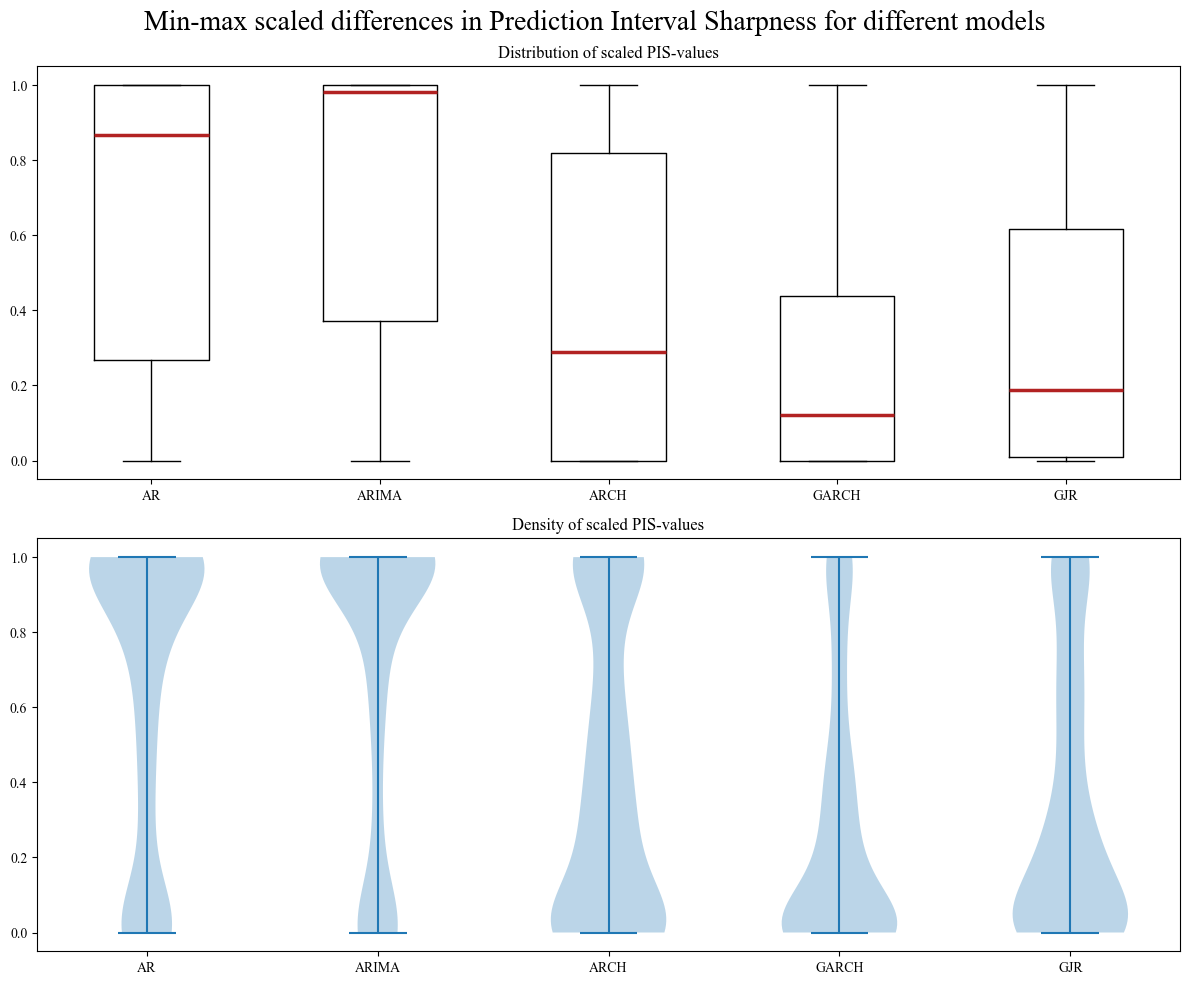

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # 2 rows, 1 column

# boxplot
axes[0].boxplot(PIS_scaled.values(), medianprops=dict(linewidth=2.5, color='firebrick'))
axes[0].set_xticklabels(PIS_scaled.keys())
axes[0].set_title("Distribution of scaled PIS-values")

# violin plot
axes[1].violinplot(PIS_scaled.values())
axes[1].set_xticks(range(1, len(PIS_scaled.keys()) + 1))  # 1-based indexing for violin plot
axes[1].set_xticklabels(RMSE_scaled.keys())
axes[1].set_title("Density of scaled PIS-values")

plt.suptitle("Min-max scaled differences in Prediction Interval Sharpness for different models", fontsize=20)
plt.tight_layout()

plt.savefig("Figures/min_max_differences_PIS.png", bbox_inches='tight');

#### (d) Bootstrapping mean distribution of every metric (RMSE, PIS) for every model

In [19]:
def bootstrap_metric_mean(metric_list, N):
    boot = np.random.choice(metric_list, (N, len(metric_list)))
    return boot.mean(axis=1)

RMSE_dict = {"AR":RMSE_AR.copy(), "ARIMA":RMSE_ARIMA.copy(), "ARCH":RMSE_ARCH.copy(), "GARCH":RMSE_GARCH.copy(), "GJR-GARCH":RMSE_GJR_GARCH.copy()}
PIS_dict = {"AR":PIS_AR.copy(), "ARIMA":PIS_ARIMA.copy(), "ARCH":PIS_ARCH.copy(), "GARCH":PIS_GARCH.copy(), "GJR-GARCH":PIS_GJR_GARCH.copy()}

RMSE_boots = dict()
PIS_boots = dict()

for model in RMSE_dict.keys():
    RMSE_boots[model] = bootstrap_metric_mean(RMSE_dict[model], 10**6)
    PIS_boots[model] = bootstrap_metric_mean(PIS_dict[model], 10**6)

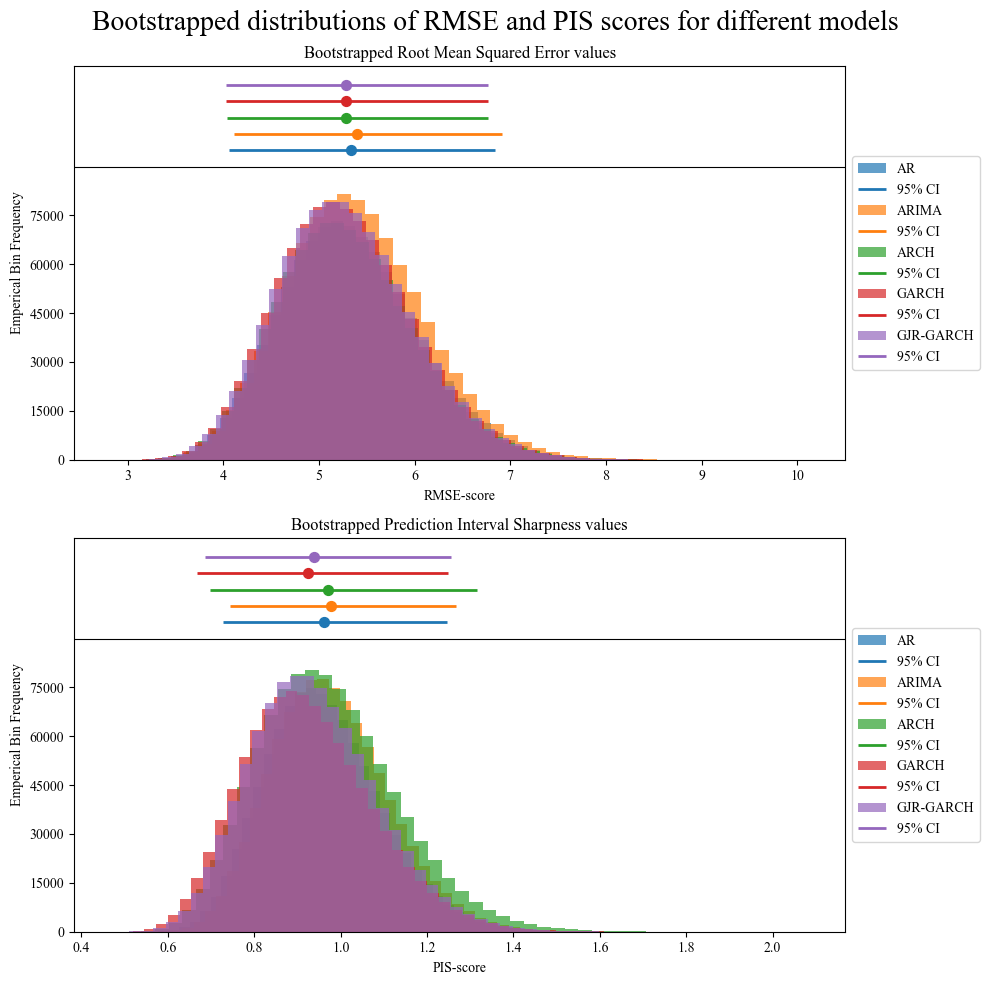

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# bootstrapped RMSE-values
for i, model in enumerate(RMSE_dict.keys()):
    ci_lower = np.percentile(RMSE_boots[model], 2.5) 
    ci_upper = np.percentile(RMSE_boots[model], 97.5)
    mean_value = np.mean(RMSE_boots[model])
    _, _, patches = axes[0].hist(RMSE_boots[model], bins=50, label=model, alpha=0.7)
    original_color = patches[0].get_facecolor()
    modified_color = (original_color[0], original_color[1], original_color[2], 1.0)
    
    axes[0].hlines(y=95000 + 5000 * i, xmin=ci_lower, xmax=ci_upper, 
                   color=modified_color, linewidth=2, label=f"95% CI")
    axes[0].scatter(mean_value, 95000 + 5000 * i, color=modified_color, s=50)  # Mean marker

axes[0].axhline(90000, color='black', linewidth=0.8)
axes[0].set_title("Bootstrapped Root Mean Squared Error values")
axes[0].set_xlabel("RMSE-score")
axes[0].set_ylabel("Emperical Bin Frequency")
axes[0].set_yticks(range(0, 90000, 15000))
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# bootstrapped PIS-values
for i, model in enumerate(PIS_dict.keys()):
    ci_lower = np.percentile(PIS_boots[model], 2.5) 
    ci_upper = np.percentile(PIS_boots[model], 97.5)
    mean_value = np.mean(PIS_boots[model])
    _, _, patches = axes[1].hist(PIS_boots[model], bins=50, label=model, alpha=0.7)
    original_color = patches[0].get_facecolor()
    modified_color = (original_color[0], original_color[1], original_color[2], 1.0)
    
    axes[1].hlines(y=95000 + 5000 * i, xmin=ci_lower, xmax=ci_upper, 
                   color=modified_color, linewidth=2, label=f"95% CI")
    axes[1].scatter(mean_value, 95000 + 5000 * i, color=modified_color, s=50)  # Mean marker

axes[1].axhline(90000, color='black', linewidth=0.8)
axes[1].set_title("Bootstrapped Prediction Interval Sharpness values")
axes[1].set_xlabel("PIS-score")
axes[1].set_ylabel("Emperical Bin Frequency")
axes[1].set_yticks(range(0, 90000, 15000))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle("Bootstrapped distributions of RMSE and PIS scores for different models", fontsize=20)
plt.tight_layout()
plt.savefig("Figures/Boot_dists_RMSE_PIS.png", bbox_inches='tight');

#### (e) Performing Mann Whitney U tests ("less" hypothesis) on bootstrapped mean distributions
- For every permutation of two models a Mann Whitney U test (less hypothesis) is performed on their respective mean distributions for the RMSE and PIS. The "less" hypothesis is chosen to determine whether one model consistently outperforms another across all companies. This is based on the principle that a lower RMSE and/or PIS value usually indicates a better model performance.
- The reason for this unparametric test, is that from the plot above the distributions seem slightly skewed, and not approximating a normal distribution very well. The reason for this is probably that both RMSE and PIS can not be negative, resulting in some skew in the mean distribution

In [21]:
#Creating two dictionaries with for every permutation of models the Mann Whitney U test with "less" hypothesis
ttestRMSE_dict = {key:[] for key in RMSE_dict.keys()}
for model1, model2 in permutations(RMSE_dict.keys(), 2):
    t_stat, p_val = stats.mannwhitneyu(RMSE_boots[model1], RMSE_boots[model2], alternative='less')
    ttestRMSE_dict[model1].append((model2,p_val))

ttestPIS_dict = {key:[] for key in RMSE_dict.keys()}
for model1, model2 in permutations(RMSE_dict.keys(), 2):
    t_stat, p_val = stats.mannwhitneyu(PIS_boots[model1], PIS_boots[model2], alternative='less')
    ttestPIS_dict[model1].append((model2,p_val))

In [22]:
#Creating two dictionaries with for every permutation of models the value 1 if the Mann Whitney U test with "less" hypothesis was significant
#and otherwise 0, this will be used for the plots later on
significant_RMSE_dict = {model: [(model, 1) if val > 0.05 else (model, 0) for model, val in test_list] for model, test_list in ttestRMSE_dict.items()}
significant_PIS_dict = {model: [(model, 1) if val > 0.05 else (model, 0) for model, val in test_list] for model, test_list in ttestPIS_dict.items()}

#Utilizing DataFrames to show the above significancy scores (1's and 0's). This makes it easier to utilize the seaborn heatmap
#plotting function later on
RMSE_significantDFs = dict()
for model in significant_RMSE_dict.keys():
    RMSE_significantDFs[model] = pd.DataFrame(dict(significant_RMSE_dict[model]).values(), index=dict(significant_RMSE_dict[model]).keys(), columns=[model]).T

PIS_significantDFs = dict()
for model in significant_RMSE_dict.keys():
    PIS_significantDFs[model] = pd.DataFrame(dict(significant_PIS_dict[model]).values(), index=dict(significant_PIS_dict[model]).keys(), columns=[model]).T

#### (f) Two plots to show models' performances on Mann Whitney U test ("less" hypotheses)

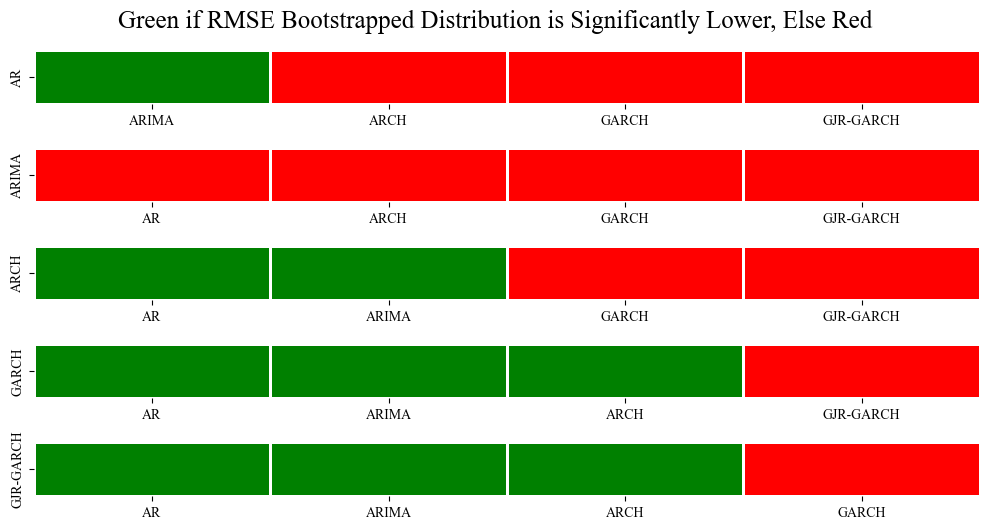

In [23]:
cmap=LinearSegmentedColormap.from_list('rg',["g", "w", "r"], N=256) 
fig, axes = plt.subplots(5, 1, figsize=(10, 5))

for i, model in enumerate(RMSE_significantDFs.keys()):
    sns.heatmap(RMSE_significantDFs[model], vmin=0, vmax=1, annot=False, linewidth=1, cbar=False, cmap=cmap, ax=axes[i])

fig.tight_layout()
fig.suptitle("Green if RMSE Bootstrapped Distribution is Significantly Lower, Else Red",y=1.05, fontsize=18)
plt.savefig("Figures/RMSE_significance_grid.png", bbox_inches='tight');

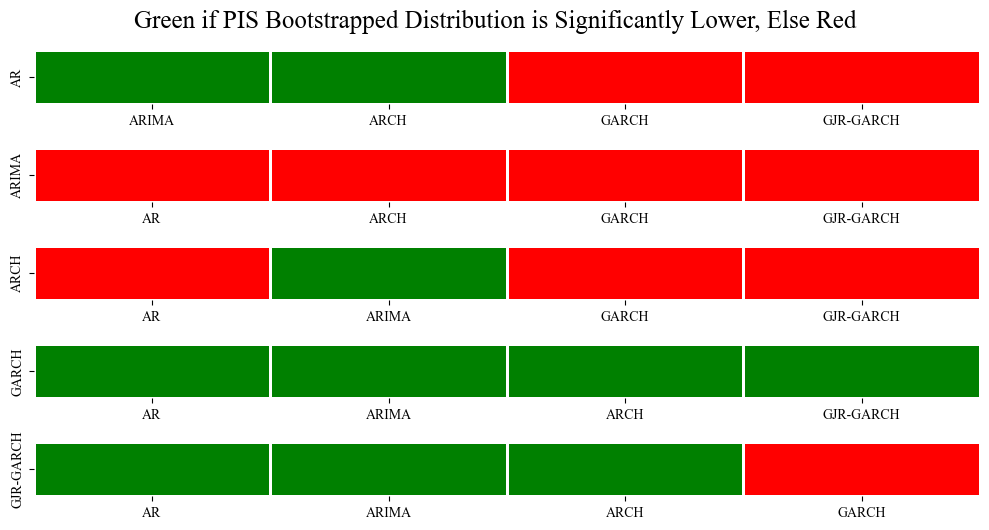

In [24]:
cmap=LinearSegmentedColormap.from_list('rg',["g", "w", "r"], N=256) 
fig, axes = plt.subplots(5, 1, figsize=(10, 5))

for i, model in enumerate(PIS_significantDFs.keys()):
    sns.heatmap(PIS_significantDFs[model], vmin=0, vmax=1, annot=False, linewidth=1, cbar=False, cmap=cmap, ax=axes[i])

fig.tight_layout()
fig.suptitle("Green if PIS Bootstrapped Distribution is Significantly Lower, Else Red",y=1.05, fontsize=18)
plt.savefig("Figures/PIS_significance_grid.png", bbox_inches='tight');

## 3. Diebold-Mariano Analysis

#### (a) Performing Diebold-Mariano tests (pairwise and all models included)

In [25]:
def dm_test(errors_1, errors_2, h=1, loss='MSE'):
    """
    Diebold-Mariano test for comparing forecast errors.
    """
    if loss == 'MSE':
        d = errors_1**2 - errors_2**2
    elif loss == 'MAE':
        d = np.abs(errors_1) - np.abs(errors_2)
    else:
        raise ValueError("Loss must be 'MSE' or 'MAE'")
    
    # mean and variance of loss diffs
    T = len(d)
    d_mean = np.mean(d)
    
    # autocovariance up to h lags
    gamma = [np.cov(d[:-k], d[k:])[0, 1] if k > 0 else np.var(d, ddof=1) for k in range(h)]
    var_d = (gamma[0] + 2 * sum(gamma[1:])) / T
    
    # DM statistic and p-value
    dm_stat = d_mean / np.sqrt(var_d)
    p_value = 2 * (1 - norm.cdf(np.abs(dm_stat)))
    
    return dm_stat, p_value

In [26]:
models = {
    "AR": AR_tDF,
    "ARIMA": ARIMA_tDF,
    "ARCH": ARCH_tDF,
    "GARCH": GARCH_tDF,
    "GJR_GARCH": GJR_GARCH_tDF,
}

# trackers
model_wins = {model: 0 for model in models.keys()}
pair_results = {pair: {"ties": 0, f"{pair[0]}_wins": 0, f"{pair[1]}_wins": 0} for pair in combinations(models.keys(), 2)}
total_ties = 0

company_tickers = list(models["AR"].keys())
for company in company_tickers:
    aligned_df = None
    
    for model_name, model_data in models.items():
        df = model_data[company][["actual", "preds"]]  # actual and preds
        df = df.dropna()
        df = df.rename(columns={"preds": model_name})  # rename preds to model name
        if aligned_df is None:
            aligned_df = df
        else:
            aligned_df = aligned_df.merge(df[[model_name]], left_index=True, right_index=True, how="inner")
    
    # forecast errors for all models
    model_errors = {}
    for model_name in models.keys():
        model_errors[model_name] = aligned_df["actual"] - aligned_df[model_name]
    
    # pairwise comparisons
    model_pairs = list(combinations(models.keys(), 2))
    model_scores = {model: 0 for model in models.keys()}
    
    for model1, model2 in model_pairs:
        errors_1 = model_errors[model1].values
        errors_2 = model_errors[model2].values
        dm_stat, p_value = dm_test(errors_1, errors_2, h=1, loss="MSE")

        # compare models: a model "wins" if it significantly outperforms the other
        if dm_stat < 0 and p_value < 0.05:  # 1 is better
            model_scores[model1] += 1
            pair_results[(model1, model2)][f"{model1}_wins"] += 1
        elif dm_stat > 0 and p_value < 0.05:  # 2 is better
            model_scores[model2] += 1
            pair_results[(model1, model2)][f"{model2}_wins"] += 1
        else:  # tie
            pair_results[(model1, model2)]["ties"] += 1
            total_ties += 1

    # determine if there is a single model that beats ALL others
    # to be the winner, model must have won against EVERY other model
    n_models = len(models)
    best_model, best_score = max(model_scores.items(), key=lambda x: x[1])
    
    # check if best_model actually beat all other models (best_score == n_models - 1)
    if best_score == n_models - 1:
        model_wins[best_model] += 1
    else:
        pass

# rank based on total wins
ranked_models = sorted(model_wins.items(), key=lambda x: x[1], reverse=True)

print("Model Ranking Based on Wins (Requires beating ALL others):")
for rank, (model, wins) in enumerate(ranked_models, start=1):
    print(f"{rank}. {model}: {wins} wins")

print("\nDetailed Pairwise Results:")
for pair, results in pair_results.items():
    print(f"{pair[0]} vs {pair[1]}: {results['ties']} ties, {pair[0]} wins: {results[f'{pair[0]}_wins']}, {pair[1]} wins: {results[f'{pair[1]}_wins']}")

print(f"\nTotal Number of Ties: {total_ties}")


Model Ranking Based on Wins (Requires beating ALL others):
1. ARIMA: 4 wins
2. AR: 1 wins
3. GJR_GARCH: 1 wins
4. ARCH: 0 wins
5. GARCH: 0 wins

Detailed Pairwise Results:
AR vs ARIMA: 496 ties, AR wins: 35, ARIMA wins: 9
AR vs ARCH: 476 ties, AR wins: 20, ARCH wins: 44
AR vs GARCH: 479 ties, AR wins: 18, GARCH wins: 43
AR vs GJR_GARCH: 482 ties, AR wins: 17, GJR_GARCH wins: 41
ARIMA vs ARCH: 465 ties, ARIMA wins: 19, ARCH wins: 56
ARIMA vs GARCH: 467 ties, ARIMA wins: 19, GARCH wins: 54
ARIMA vs GJR_GARCH: 470 ties, ARIMA wins: 17, GJR_GARCH wins: 53
ARCH vs GARCH: 518 ties, ARCH wins: 3, GARCH wins: 19
ARCH vs GJR_GARCH: 516 ties, ARCH wins: 6, GJR_GARCH wins: 18
GARCH vs GJR_GARCH: 522 ties, GARCH wins: 10, GJR_GARCH wins: 8

Total Number of Ties: 4891


#### (b) Plotting the pairwise results

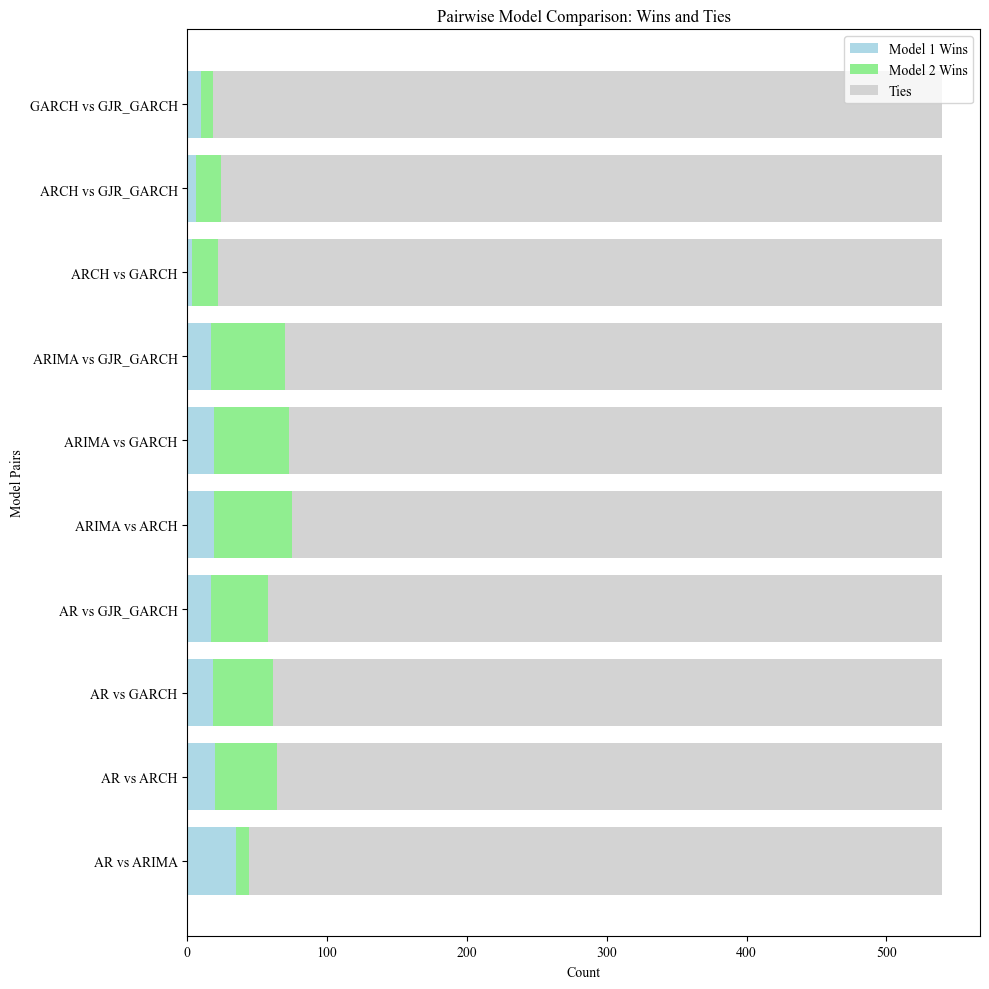

In [27]:
# extract pairwise results into lists for plotting
pairs = [f"{pair[0]} vs {pair[1]}" for pair in pair_results.keys()]
model1_wins = [results[f"{pair[0]}_wins"] for pair, results in pair_results.items()]
model2_wins = [results[f"{pair[1]}_wins"] for pair, results in pair_results.items()]
ties = [results["ties"] for results in pair_results.values()]

plt.figure(figsize=(10, 10))
plt.barh(pairs, model1_wins, label="Model 1 Wins", color="lightblue")
plt.barh(pairs, model2_wins, left=model1_wins, label="Model 2 Wins", color="lightgreen")
plt.barh(pairs, ties, left=np.array(model1_wins) + np.array(model2_wins), label="Ties", color="lightgray")

plt.title("Pairwise Model Comparison: Wins and Ties")
plt.xlabel("Count")
plt.ylabel("Model Pairs")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/DM_test_pairwise.png")
plt.show();


#### (c) Plotting the results of all models included

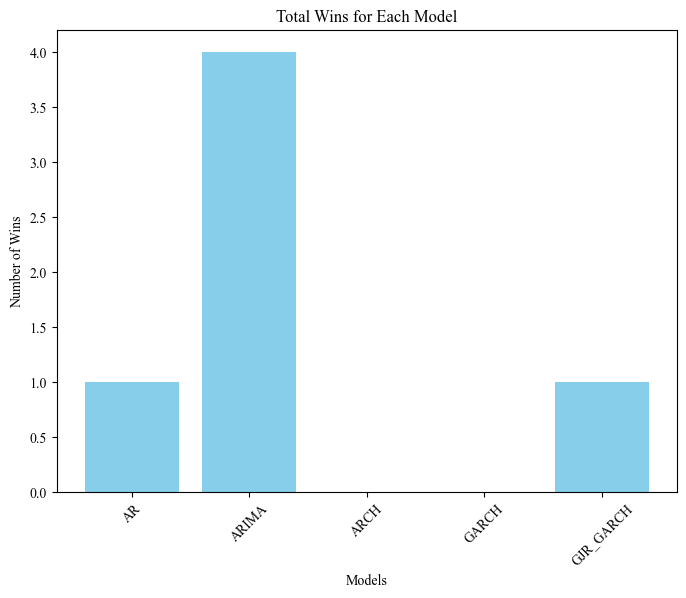

In [28]:
plt.figure(figsize=(8, 6))
plt.bar(model_wins.keys(), model_wins.values(), color="skyblue")
plt.title("Total Wins for Each Model")
plt.ylabel("Number of Wins")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.show()

## 4. Plot for CDS-rates of McDonald's
- A simple plot that is used in the presentation, for explaining significance of comparing forecasting models in the undpredictable Covid-19 times

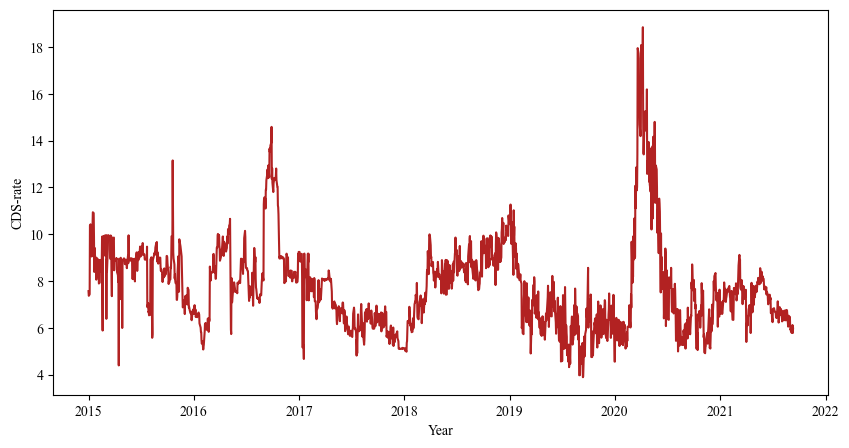

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(cds_DF[cds_DF['Ticker'] == 'MCD']['Date'], cds_DF[cds_DF['Ticker'] == 'MCD']['PX1'], color='firebrick');
plt.xlabel("Year")
plt.ylabel("CDS-rate");
plt.savefig("Figures/CDSratesMCD.png")

## 5. Conclusion

#### (a) Hypotheses that are in our project plan
__Hypothesis 1:__ 
- $H_0$: The GJR-GARCH model will outperform the ARCH and GARCH models.
- $H_1$: The  GJR-GARCH model does not significantly outperform the ARCH and GARCH models.

__Hypothesis 2:__
- $H_0$: The ARIMA model will outperform the AR model.
- $H_1$: The ARIMA model will not significantly outperform the AR model.

__Hypothesis 3:__ 
- $H_0$: The GARCH family of models will outperform the AR family (given the volatility-driven dynamics of the COVID pandemic).
- $H_1$: The GARCH models do not significantly outperform the AR models.

#### (b) Evaluating our hypotheses
__Hypothesis 1:__ Reject $H_0$ 
- Both when looking at the paired Diebold-Mariano tests and also the Mann Whitney U tests, the GJR-GARCH model did not perform significantly better than the GARCH model. We will therefore reject the notion that the GJR-GARCH model outperformed the ARCH and GARCH models.

__Hypothesis 2:__ Reject $H_0$
- Both the paired Diebold-Mariano tests and the Mann Whitney U tests, did not show that ARIMA outperformed the AR model (maybe even the other way around). Even though the non-paired Diebold-Mariano test which included all models at once showed that the ARIMA-model won the most times (4 times). This is still only 4 times out of 540 companies. Meaning that for an overwhelming majority of the companies, there were ties. Therefore we reject the notion that the ARIMA model performed better than the AR model.

__Hypothesis 3:__ Don't reject $H_0$
- Both the paired Diebold-Mariano tests and Mann Whitney U tests, showed that generally the GARCH family outperformed the AR and ARIMA models. So, even though there were a lot of ties in the Diebold-Mariano test, the GARCH family still generally won a lot more times than the ARIMA-family. We therefore do not reject the claim that the GARCH family outperformed the AR family